In [1]:
#Pindah direktori ke direktori tempat data 
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm
import glob as glob
import matplotlib.ticker as tk
import matplotlib.patches as mpatches

In [4]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [6]:
erossbyolrdata=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_olr.nc')
mrossbyolrdata=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_mrg_olr.nc')
kelvinolrdata=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_kelvin_olr.nc')
erossbyolr=erossbyolrdata['olr_er'].sel(time=erossbyolrdata.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000')).sel(lat=slice(-25,25), lon=slice(80,130))
mrossbyolr=mrossbyolrdata['olr_mrg'].sel(time=mrossbyolrdata.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000')).sel(lat=slice(-25,25), lon=slice(80,130))
kelvinolr=kelvinolrdata['olr_kelvin'].sel(time=kelvinolrdata.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000')).sel(lat=slice(-25,25), lon=slice(80,130))
erossbyv=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_er_v.nc')
mrossbyv=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_mrg_v.nc')
kelvinv=xr.open_dataset('E:\CobaWK99\Data Hasil Filter\wk_kelvin_v.nc')
erossbyv=erossbyv['v_er'].sel(time=erossbyv.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000')).sel(lat=slice(-25,25), lon=slice(80,130))
mrossbyv=mrossbyv['v_mrg'].sel(time=mrossbyv.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000')).sel(lat=slice(-25,25), lon=slice(80,130))
kelvinv=kelvinv['v_kelvin'].sel(time=kelvinv.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000')).sel(lat=slice(-25,25), lon=slice(80,130))
lat=erossbyolr['lat'].values
lon=erossbyolr['lon'].values
latv=erossbyv['lat'].values
lonv=erossbyv['lon'].values
timedjf=erossbyolr['time'].values

In [9]:
#Read time-event excel data
censidx=pd.read_excel('calculation_output\CENS Index NDJFM.xlsx')
dscensidx = xr.Dataset(
     {"index": (("time"), censidx['cens index'].values)},
    coords={
    "time": censidx['time'].values,
    },
    )
dscensdjf=dscensidx.sel(time=dscensidx.time.dt.season=="DJF").sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
censspat=np.tile(dscensdjf['index'].values[:, np.newaxis, np.newaxis], (1, len(lat), len(lon)))
dscensidx = xr.Dataset(
     {"index": (("time", "lat", "lon"), censspat)},
    coords={
    "time": timedjf,
    "lat": lat,
    "lon": lon,
    },
    )
censspatv=np.tile(dscensdjf['index'].values[:, np.newaxis, np.newaxis], (1, len(latv), len(lonv)))
dscensidxv = xr.Dataset(
     {"index": (("time", "lat", "lon"), censspatv)},
    coords={
    "time": timedjf,
    "lat": latv,
    "lon": lonv,
    },
    )

In [10]:
er1=erossbyolrdata.sel(lat= slice(3,14), lon=slice(86,101), time=slice('1979-01-01T00:00:00.000000000','2021-12-31T00:00:00.000000000')).mean(dim=('lat','lon'))['olr_er']
er2=erossbyolrdata.sel(lat= slice(-16,-4), lon=slice(113,128), time=slice('1979-01-01T00:00:00.000000000','2021-12-31T00:00:00.000000000')).mean(dim=('lat','lon'))['olr_er']
idxer=er1-er2
mrg1 = mrossbyolrdata.sel(lat= slice(2,9), lon=slice(97,110), time=slice('1979-01-01T00:00:00.000000000','2021-12-31T00:00:00.000000000') )['olr_mrg']
mrg2 = mrossbyolrdata.sel(lat= slice(-6,-3), lon=slice(105,117), time=slice('1979-01-01T00:00:00.000000000','2021-12-31T00:00:00.000000000'))['olr_mrg']
idxmrg=(mrg1.mean(dim=('lat','lon'))-mrg2.mean(dim=('lat','lon')))
time=idxer['time'][1:-1].values
dtidxmrg=(idxmrg[2:].values-idxmrg[:-2].values)/2
dtidxer=(idxer[2:].values-idxer[:-2].values)/2
idxmrgcut=idxmrg[1:-1].values
idxercut=idxer[1:-1].values

#Normalization
idxmrgcut=idxmrgcut/np.std(idxmrgcut)
idxercut=idxercut/np.std(idxercut)
dtidxmrg=dtidxmrg/np.std(dtidxmrg)
dtidxer=dtidxer/np.std(dtidxer)
tglidxermrg=pd.DataFrame({'time': time,
                         'olrmrg':idxmrgcut,
                         'dtolrmrg'  :dtidxmrg,
                         'olrer' :idxercut,
                         'dtolrer'   :dtidxer,
                          })
tglidxermrg=tglidxermrg.set_index('time')

#Read time-event excel data
censevt=pd.read_excel('calculation_output\CENS Event 3 days Running Mean.xlsx')
censevt=censevt.set_index('time_cens')
tcensnocs=censevt[censevt['cs event']==0].index

In [23]:
#Read EW MRG excel
ewevt=pd.read_excel('calculation_output\Indeks ER MRG Double Side ER EWNS.xlsx')

#Climatology Amplitude EW
ewevtxarray = xr.Dataset(
     {"amp mrg": (("time"), ewevt['amp mrg'].values), "amp er": (("time"), ewevt['amp er'].values)},
    coords={
    "time":   ewevt['time'].values},
    )
ewevtdjf=ewevtxarray.sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
ewevtdjf=ewevtdjf.sel(time=ewevtdjf.time.dt.season=="DJF")
print('threshold MRG ', (ewevtdjf['amp mrg'].mean()+0*ewevtdjf['amp mrg'].std()).values)
thresmrg=(ewevtdjf['amp mrg'].mean()+0*ewevtdjf['amp mrg'].std()).values

#Slice MRG in CENS-noCS event
ewslice=ewevt.set_index(['time']).loc[tcensnocs]
tglcensmrg1 = ewslice.set_index(['amp mrg'])
tglcensmrg1 = tglcensmrg1[tglcensmrg1.index.get_level_values('amp mrg')>=thresmrg]

#Get each MRG phase event climatology
tglcensmrgph=ewevt.set_index(['amp mrg', 'phase mrg'])
tglcensmrgamp=tglcensmrgph[tglcensmrgph.index.get_level_values('amp mrg')>thresmrg]
tglmrgeveryph=[]
for i in range(4):
    tgl=tglcensmrgamp[tglcensmrgamp.index.get_level_values('phase mrg')==i+1]
    tglmrgeveryph.append(tgl['time'].values)

ewevtxarray = xr.Dataset(
     {"amp mrg": (("time"), ewevt['amp mrg'].values), "amp er": (("time"), ewevt['amp er'].values)},
    coords={
    "time":   ewevt['time'].values},
    )
ewevtdjf=ewevtxarray.sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
ewevtdjf=ewevtdjf.sel(time=ewevtdjf.time.dt.season=="DJF")
print('threshold ER ',(ewevtdjf['amp er'].mean()+0*ewevtdjf['amp er'].std()).values)
threser=(ewevtdjf['amp er'].mean()+0*ewevtdjf['amp er'].std()).values

#Slice ER in CENS-noCS event
ewslice=ewevt.set_index(['time']).loc[tcensnocs]
tglcenser1 = ewslice.set_index(['amp er'])
tglcenser1 = tglcenser1[tglcenser1.index.get_level_values('amp er')>=threser]

#Get each ER phase event climatology
tglcenserph=ewevt.set_index(['amp er', 'phase er'])
tglcenseramp=tglcenserph[tglcenserph.index.get_level_values('amp er')>=threser]
tglereveryph=[]
for i in range(4):
    tgl=tglcenseramp[tglcenseramp.index.get_level_values('phase er')==i+1]
    tglereveryph.append(tgl['time'].values)

threshold MRG  1.2258041202083383
threshold ER  1.3604651167535824


In [12]:
#Read data
datav925mrg = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_mrg_v.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
datau925mrg = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_mrg_u.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
datamslpmrg = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_mrg_slp.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
dataolrmrg = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_mrg_olr.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
anv925mrg = datav925mrg['v_mrg'].sel(time=datav925mrg.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
anu925mrg = datau925mrg['u_mrg'].sel(time=datau925mrg.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
anslpmrg = datamslpmrg['slp_mrg'].sel(time=datamslpmrg.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
anolrmrg = dataolrmrg['olr_mrg'].sel(time=dataolrmrg.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
latmrg=anv925mrg['lat'].values
lonmrg=anv925mrg['lon'].values
latolrmrg=anolrmrg['lat'].values
lonolrmrg=anolrmrg['lon'].values

#Read data
datav925er = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_er_v.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
datau925er = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_er_u.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
datamslper = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_er_slp.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
dataolrer = xr.open_mfdataset('E:\CobaWK99\Data Hasil Filter\wk_er_olr.nc').sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
anv925er = datav925er['v_er'].sel(time=datav925er.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
anu925er = datau925er['u_er'].sel(time=datau925er.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
anslper = datamslper['slp_er'].sel(time=datamslper.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
anolrer = dataolrer['olr_er'].sel(time=dataolrer.time.dt.season=="DJF").sel(lat= slice(-15,15), lon=slice(90,130))
later=anv925er['lat'].values
loner=anv925er['lon'].values
latolrer=anolrer['lat'].values
lonolrer=anolrer['lon'].values
slpdjfmrg= anslpmrg.load()
u925djfmrg= anu925mrg.load()
v925djfmrg= anv925mrg.load()
slpdjfer= anslper.load()
u925djfer= anu925er.load()
v925djfer= anv925er.load()

In [24]:
pvaluemslpmrg=np.empty([4, len(slpdjfmrg['lat']), len(slpdjfmrg['lon'])])
data=slpdjfmrg
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglmrgeveryph[c]), 1000, 1)
    compositemean=slpdjfmrg.sel(time=np.in1d(slpdjfmrg.time, tglmrgeveryph[c])).mean(dim='time')
    pvaluemslpmrg[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluemslptfmrg=pvaluemslpmrg

pvalueu925mrg=np.empty([4, len(u925djfmrg['lat']), len(u925djfmrg['lon'])])
data=u925djfmrg
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglmrgeveryph[c]), 1000, 1)
    compositemean=u925djfmrg.sel(time=np.in1d(u925djfmrg.time, tglmrgeveryph[c])).mean(dim='time')
    pvalueu925mrg[c]=np.logical_or(compositemean<low, compositemean>high).values
pvalueu925tfmrg=pvalueu925mrg

pvaluev925mrg=np.empty([4, len(v925djfmrg['lat']), len(v925djfmrg['lon'])])
data=v925djfmrg
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglmrgeveryph[c]), 1000, 1)
    compositemean=v925djfmrg.sel(time=np.in1d(v925djfmrg.time, tglmrgeveryph[c])).mean(dim='time')
    pvaluev925mrg[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluev925tfmrg=pvaluev925mrg

pvalueuv925tfmrg=np.logical_or(pvalueu925tfmrg, pvaluev925tfmrg)
pvalueuv925tfmrg=pvalueuv925tfmrg.astype(float)
pvalueuv925tfmrg[pvalueuv925tfmrg==0] = np.nan

pvaluemslper=np.empty([4, len(slpdjfer['lat']), len(slpdjfer['lon'])])
data=slpdjfer
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=slpdjfer.sel(time=np.in1d(slpdjfer.time, tglereveryph[c])).mean(dim='time')
    pvaluemslper[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluemslptfer=pvaluemslper

pvalueu925er=np.empty([4, len(u925djfer['lat']), len(u925djfer['lon'])])
data=u925djfer
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=u925djfer.sel(time=np.in1d(u925djfer.time, tglereveryph[c])).mean(dim='time')
    pvalueu925er[c]=np.logical_or(compositemean<low, compositemean>high).values
pvalueu925tfer=pvalueu925er

pvaluev925er=np.empty([4, len(v925djfer['lat']), len(v925djfer['lon'])])
data=v925djfer
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglereveryph[c]), 1000, 1)
    compositemean=v925djfer.sel(time=np.in1d(v925djfer.time, tglereveryph[c])).mean(dim='time')
    pvaluev925er[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluev925tfer=pvaluev925er

pvalueuv925tfer=np.logical_or(pvalueu925tfer, pvaluev925tfer)
pvalueuv925tfer=pvalueuv925tfer.astype(float)
pvalueuv925tfer[pvalueuv925tfer==0] = np.nan

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.70it/s]


In [33]:
#Monte carlo test MRG
nloop=2000
rfrq=np.empty([nloop,4])
prc=np.empty([4])
thres=np.empty([5])
for i in range(nloop):
    ridx=np.random.randint(1, high=5, size=tglcensmrg1['phase mrg'].value_counts().sum())
    for ip in range(4):
        rfrq[i,ip]=len(np.where(ridx==ip+1)[0])
for ip in range (4):
    prc[ip]=np.percentile(rfrq[:,ip],99.5)
print('Thres Monte Carlo CENS-noCS Frequency in MRG')
print(prc)

Thres Monte Carlo CENS-noCS Frequency in MRG
[10. 10. 10. 10.]


In [19]:
#Monte carlo test ER
nloop=2000
rfrq=np.empty([nloop,4])
prc=np.empty([4])
thres=np.empty([5])
for i in range(nloop):
    ridx=np.random.randint(1, high=5, size=tglcenser1['phase er'].value_counts().sum())
    for ip in range(4):
        rfrq[i,ip]=len(np.where(ridx==ip+1)[0])
for ip in range (4):
    prc[ip]=np.percentile(rfrq[:,ip],99.5)
print('Thres Monte Carlo CENS-noCS Frequency in ER')
print(prc)

Thres Monte Carlo CENS-noCS Frequency in ER
[11. 11. 11. 11.]


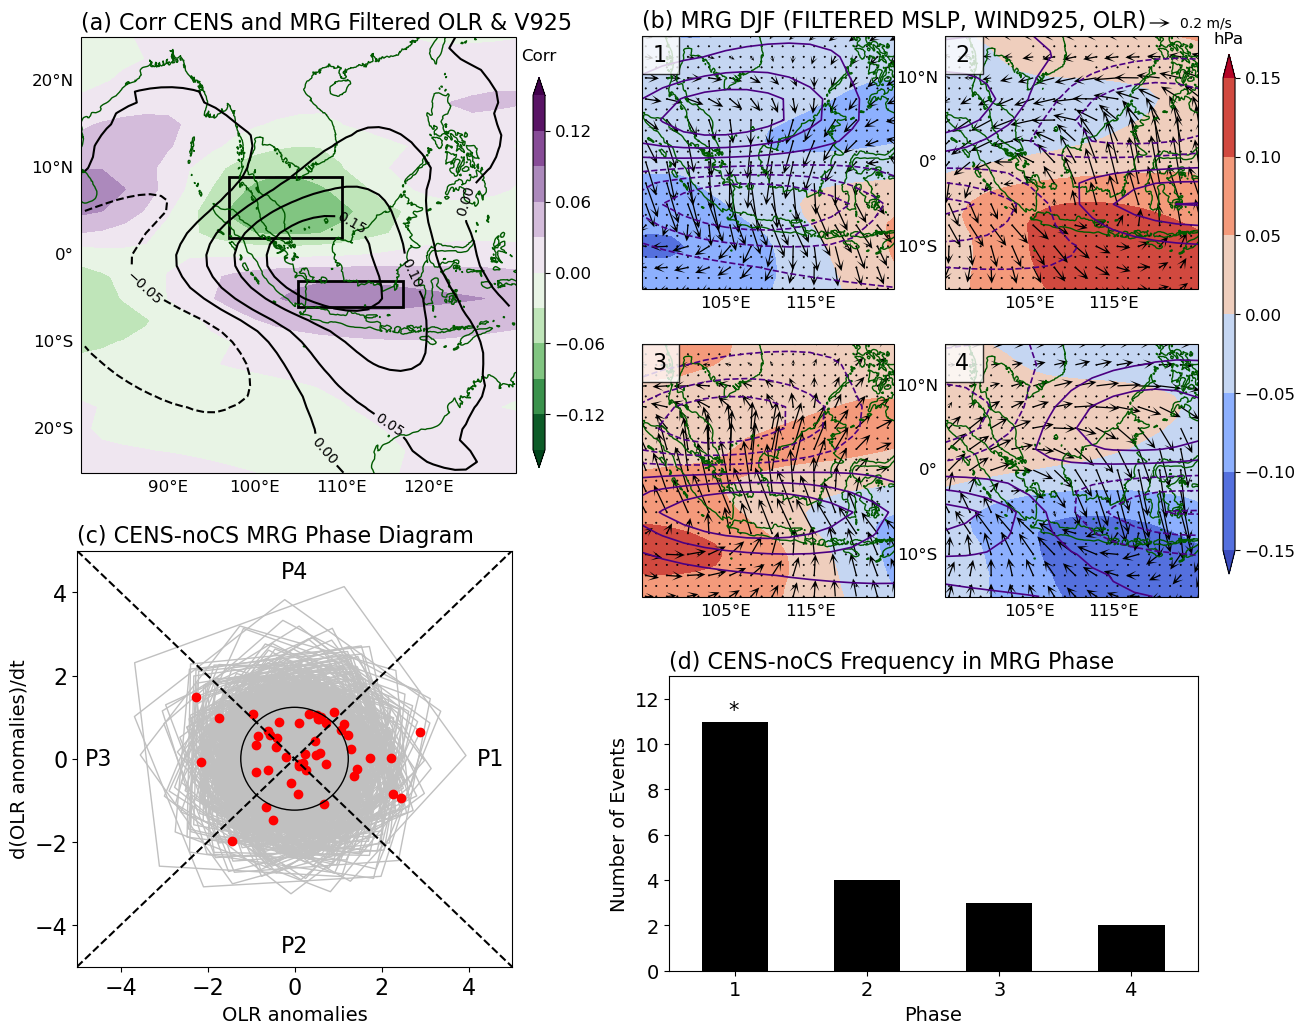

In [34]:
fig = plt.figure(figsize=(15,13))
fig.tight_layout()

#Plot Correlation CENS and Filtered OLR (MRG)
ax = fig.add_axes([0.133, 0.493, 0.335, 0.335], projection=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True,linewidth=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12} 
gl.ylabel_style = {'size': 12} 
value=xr.corr(mrossbyolr, dscensidx['index'], dim="time")
plotval=ax.contourf(lon, lat, value, transform=ccrs.PlateCarree(),
          cmap='PRGn_r',
          levels=np.arange(-0.15, 0.16, 0.03), 
          extend='both'
          )
valuev=xr.corr(mrossbyv, dscensidxv['index'], dim="time")
plotv=ax.contour(lonv, latv, valuev, transform=ccrs.PlateCarree(), colors='k', 
                 levels=np.arange(-0.5,0.16,0.05)
                )
ax.clabel(plotv, inline=True, fontsize=10)
longitude1, latitude1 = 97, 2
longitude2, latitude2 = 110, 9
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            edgecolor='k', linewidth=2, facecolor='none',
                            transform=ccrs.PlateCarree()))
longitude1, latitude1 = 105, -6
longitude2, latitude2 = 117, -3
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            edgecolor='k', linewidth=2, facecolor='none',
                            transform=ccrs.PlateCarree()))
ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
ax.set_title('(a) Corr CENS and MRG Filtered OLR & V925', loc='left', fontsize=16)
cbar_ax = fig.add_axes([0.457, 0.497, 0.008, 0.3])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('Corr', pad=25, fontsize=12)
cbar.ax.tick_params(labelsize=12)

#Plot Phase Diagram (MRG)
ax=fig.add_axes([0.153, 0.113, 0.29, 0.32])
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.tick_params(labelsize=16)
ax.axline(xy1=(0, 0), slope=1, linestyle='--', c='k', zorder=4)
ax.axline(xy1=(0, 0), slope=-1, linestyle='--', c='k', zorder=4)
ax.text(0, -4.5, 'P2', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax.text(0, 4.5, 'P4', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax.text(4.5, 0, 'P1', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax.text(-4.5, 0, 'P3', horizontalalignment='center', verticalalignment='center', fontsize=16)
for year in np.arange(1979,2020,1):
    data=tglidxermrg.loc[pd.date_range(str(year)+'-12-01',str(year+1)+'-02-28')]
    plt.plot(data['olrmrg'],data['dtolrmrg'], c='silver', linewidth=1)
circle1=plt.Circle((0, 0), ( 1.236), color='k', fill=False, zorder=4)
ax.add_patch(circle1)
datanocs=tglidxermrg.loc[tcensnocs]
ax.scatter(datanocs['olrmrg'],datanocs['dtolrmrg'], c='r', zorder=3)
ax.set_title('(c) CENS-noCS MRG Phase Diagram', loc='left', fontsize=16)
ax.set_xlabel('OLR anomalies', fontsize=14)
ax.set_ylabel('d(OLR anomalies)/dt', fontsize=14)

#Plot Composite MRG Each Phase
for img, sbp in zip(np.arange(0,4,1), [343,344,347,348]):
    ax = fig.add_subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([95, 125, -15, 15])
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([95, 105, 115])
    gl.ylocator = tk.FixedLocator([-10, 0, 10])
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}    
    if img==0 or  img==2:
        gl.left_labels = False
    pltctr=ax.contour(lonolrmrg, latolrmrg, anolrmrg.sel(time=np.in1d(anolrmrg.time, tglmrgeveryph[img])).mean(dim='time'), 
              transform=ccrs.PlateCarree(),
              levels=np.arange(-5,6,2), 
              extend='both', colors='indigo', linewidths=1.2
              )
    dset=anslpmrg/100
    value=dset.sel(time=np.in1d(dset.time, tglmrgeveryph[img])).mean(dim='time')
    plotval=ax.contourf(lonmrg, latmrg, value, transform=ccrs.PlateCarree(),
              cmap='coolwarm',
              levels=np.arange(-0.15,0.16,0.05), 
              extend='both'
              )
    x,y=np.meshgrid(lonmrg, latmrg)
    skipp=1
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluemslptfmrg[img]*1,color='k', linewidth=0.4)
    uu=anu925mrg.sel(time=np.in1d(anu925mrg.time, tglmrgeveryph[img])).mean(dim='time')
    vv=anv925mrg.sel(time=np.in1d(anv925mrg.time, tglmrgeveryph[img])).mean(dim='time')
    skip = 2
    Qwd1=ax.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*pvalueuv925tfmrg[img][::skip, ::skip], vv[::skip, ::skip]*pvalueuv925tfmrg[img][::skip, ::skip], color='k', scale=1 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('(b) MRG DJF (FILTERED MSLP, WIND925, OLR)', loc='left', fontsize=16)
    longitude1, latitude1 = 95, 10.5
    longitude2, latitude2 = 99.5, 15
    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                            transform=ccrs.PlateCarree()))
    ax.text(96.25,12,str(1+img),fontsize=16, c='k')
    if img==1:
        qk = plt.quiverkey(Qwd1, 
                  0.89, 1.05,                  
                  0.2,str(0.2)+' m/s',   
                  labelpos='E',               
                  coordinates='axes'
                   )  
cbar_ax = fig.add_axes([0.917, 0.415, 0.008, 0.4])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('hPa', pad=25, fontsize=12)
cbar.ax.tick_params(labelsize=12)

#Plot CENS-noCS Frequency in MRG Phase
ax = fig.add_subplot(428)
tglcensmrg1['phase mrg'].value_counts().sort_index().plot(kind='bar', color='k', ax=ax)
ax.text(-0.05,11.25,'*',fontsize=15)
ax.set_ylim([0,13])
ax.set_title('(d) CENS-noCS Frequency in MRG Phase', loc='left', fontsize=16)
ax.set_xlabel('Phase', fontsize=14)
ax.set_ylabel('Number of Events', fontsize=14)
ax.set_xticks((np.arange(0,3.1,1)))
ax.set_xticklabels(['1','2','3','4'],fontsize=14, rotation=0)
ax.set_yticks((np.arange(0,13,2)))
ax.set_yticklabels(np.arange(0,13,2),fontsize=14, rotation=0)

plt.subplots_adjust(hspace=-0.2, wspace=0.2)
plt.savefig('figure_output\Fig 8.pdf', bbox_inches='tight')
plt.show()

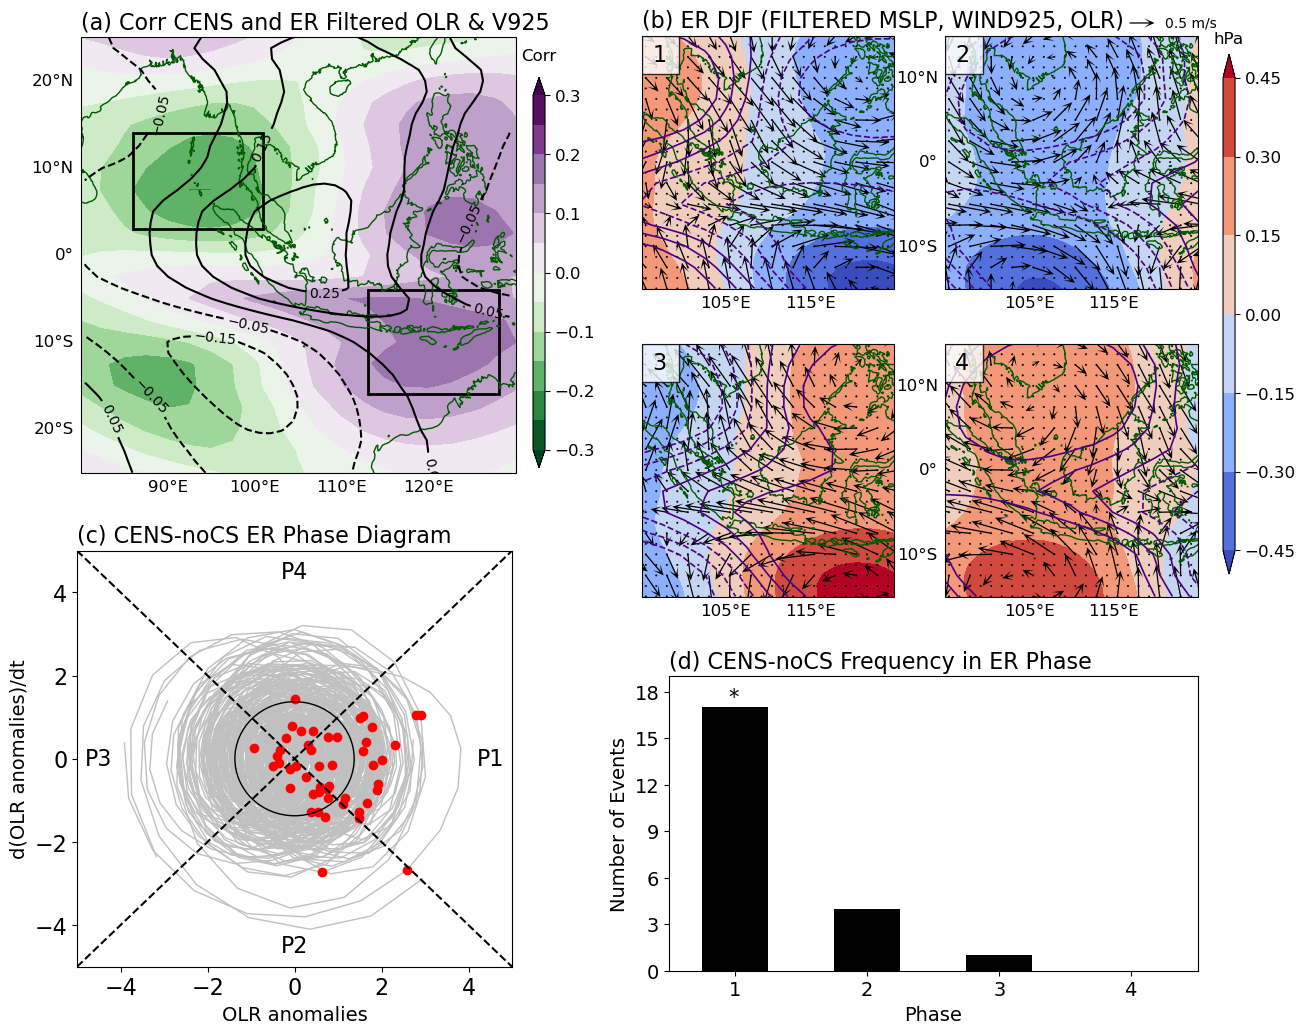

In [22]:
fig = plt.figure(figsize=(15,13))
fig.tight_layout()

#Plot Correlation CENS and Filtered OLR (ER)
ax = fig.add_axes([0.133, 0.493, 0.335, 0.335], projection=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True,linewidth=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
value=xr.corr(erossbyolr, dscensidx['index'], dim="time")
plotval=ax.contourf(lon, lat, value, transform=ccrs.PlateCarree(),
          cmap='PRGn_r',
          levels=np.arange(-0.3, 0.31, 0.05), 
          extend='both'
          )
valuev=xr.corr(erossbyv, dscensidxv['index'], dim="time")
plotv=ax.contour(lonv, latv, valuev, transform=ccrs.PlateCarree(), colors='k', levels=np.arange(-0.25,0.26,0.1))
ax.clabel(plotv, inline=True, fontsize=10)
longitude1, latitude1 = 128, -16
longitude2, latitude2 = 113, -4
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            edgecolor='k', linewidth=2, facecolor='none',
                            transform=ccrs.PlateCarree()))
longitude1, latitude1 = 101, 3
longitude2, latitude2 = 86, 14
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            edgecolor='k', linewidth=2, facecolor='none',
                            transform=ccrs.PlateCarree()))
ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
ax.set_title('(a) Corr CENS and ER Filtered OLR & V925', loc='left', fontsize=16)
cbar_ax = fig.add_axes([0.457, 0.497, 0.008, 0.3])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('Corr', pad=25, fontsize=12)
cbar.ax.tick_params(labelsize=12)

#Plot Phase Diagram (ER)
ax = fig.add_axes([0.153, 0.113, 0.29, 0.32])
ax.set_title('(c) CENS-noCS ER Phase Diagram', loc='left', fontsize=16)
ax.set_xlabel('OLR anomalies', fontsize=14)
ax.set_ylabel('d(OLR anomalies)/dt', fontsize=14)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.tick_params(labelsize=16)
ax.axline(xy1=(0, 0), slope=1, linestyle='--', c='k', zorder=4)
ax.axline(xy1=(0, 0), slope=-1, linestyle='--', c='k', zorder=4)
ax.text(0, -4.5, 'P2', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax.text(0, 4.5, 'P4', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax.text(4.5, 0, 'P1', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax.text(-4.5, 0, 'P3', horizontalalignment='center', verticalalignment='center', fontsize=16)
for year in np.arange(1979,2020,1):
    data=tglidxermrg.loc[pd.date_range(str(year)+'-12-01',str(year+1)+'-02-28')]
    ax.plot(data['olrer'],data['dtolrer'], c='silver', linewidth=1)
circle1=plt.Circle((0, 0), (1.371), color='k', fill=False, zorder=4)
ax.add_patch(circle1)
datanocs=tglidxermrg.loc[tcensnocs]
ax.scatter(datanocs['olrer'],datanocs['dtolrer'], c='r', zorder=3)

#Plot Composite ER Each Phase
for img, sbp in zip(np.arange(0,4,1), [343,344,347,348]):
    ax = plt.subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([95, 125, -15, 15])
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([95, 105, 115])
    gl.ylocator = tk.FixedLocator([-10, 0, 10])
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12} 
    if img==0 or  img==2:
        gl.left_labels = False
    pltctr=ax.contour(lonolrmrg, latolrmrg, anolrer.sel(time=np.in1d(anolrer.time, tglereveryph[img])).mean(dim='time'), 
              transform=ccrs.PlateCarree(),
              levels=np.arange(-5,6,2), 
              extend='both', colors='indigo', linewidths=1.2
              )
    dset=anslper/100
    value=dset.sel(time=np.in1d(dset.time, tglereveryph[img])).mean(dim='time')
    plotval=ax.contourf(loner, later, value, transform=ccrs.PlateCarree(),
              cmap='coolwarm',
              levels=np.arange(-0.45, 0.46, 0.15), 
              extend='both'
              )
    x,y=np.meshgrid(loner, later)
    skipp=1
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluemslptfer[img]*1,color='k', linewidth=0.4)
    uu=anu925er.sel(time=np.in1d(anu925er.time, tglereveryph[img])).mean(dim='time')
    vv=anv925er.sel(time=np.in1d(anv925er.time, tglereveryph[img])).mean(dim='time')
    skip = 2
    Qwd1=ax.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*pvalueuv925tfer[img][::skip, ::skip], vv[::skip, ::skip]*pvalueuv925tfer[img][::skip, ::skip], color='k', scale=2 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('(b) ER DJF (FILTERED MSLP, WIND925, OLR)', loc='left', fontsize=16)
    longitude1, latitude1 = 95, 10.5
    longitude2, latitude2 = 99.5, 15
    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                            facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                            transform=ccrs.PlateCarree()))
    ax.text(96.25,12,str(1+img),fontsize=16, c='k')
    if img==1:
        qk = plt.quiverkey(Qwd1, 
                  0.83, 1.05,                  
                  0.5,str(0.5)+' m/s',   
                  labelpos='E',               
                  coordinates='axes'
                   )   
cbar_ax = fig.add_axes([0.917, 0.415, 0.008, 0.4])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('hPa', pad=25, fontsize=12)
cbar.ax.tick_params(labelsize=12)

#Plot CENS-noCS Frequency in ER Phase
ax = plt.subplot(428)
tglcenser1['phase er'].value_counts().sort_index().plot(kind='bar', color='k', ax=ax)
ax.text(-0.05,17.25,'*',fontsize=15)
ax.set_ylim([0,19])
ax.set_xlim([-0.5,3.5])
ax.set_title('(d) CENS-noCS Frequency in ER Phase', loc='left', fontsize=16)
ax.set_xlabel('Phase', fontsize=14)
ax.set_xticks((np.arange(0,3.1,1)))
ax.set_xticklabels(['1','2','3','4'],fontsize=14, rotation=0)
ax.set_yticks((np.arange(0,19,3)))
ax.set_yticklabels(np.arange(0,19,3),fontsize=14, rotation=0)
ax.set_ylabel('Number of Events', fontsize=14)

plt.subplots_adjust(hspace=-0.2, wspace=0.2)
plt.savefig('figure_output\Fig 9.pdf', bbox_inches='tight')
plt.show()